## Loading (JAZZ) data

In [43]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os


In [44]:



def file_exists(file_path):
    return os.path.isfile(file_path)


skip_graphs= ['p2p-Gnutella04','CA-HepTh', 'arenas-pgp', 'powergrid','NS', 'faa', 'ChicagoRegional', 'ia-crime-moreno', 'maybe-PROTEINS-full', 'sex']

def get_test_graph_paths(dataset_dir= "./../datasets/"):
    graph_list = []
    for dirpath, _, files in os.walk(dataset_dir):
        for filename in files:
            try:
                if filename.endswith(".edges") :
                    if not filename.startswith("ba_edgelist"):
                        file_path = os.path.join(dirpath, filename) 
                        graph_list.append((file_path, os.path.splitext(filename)[0]))
            except Exception as e: 
                print(e, f'{filename}')
    return graph_list

def get_train_graph_paths(dataset_dir= "./../datasets/"):
    graph_list = []
    for dirpath, _, files in os.walk(dataset_dir):
        for filename in files:
            try:
                if filename.endswith(".edges") :
                    if filename.startswith("ba_edgelist_exp"):
                        file_path = os.path.join(dirpath, filename) 
                        graph_list.append((file_path, os.path.splitext(filename)[0]))
            except Exception as e: 
                print(e, f'{filename}')
    return graph_list

def get_graph_path(graph_list, graph_name):
    for graph in graph_list:
        if graph[1]==graph_name:
            return graph[0]
    return None

def get_sir_paths(net_name, num_b=3,  result_path = './../datasets/SIR_Results/'):
    paths= []
    for i in range(num_b):
        sir_dir =os.path.join(result_path, net_name)
        sir_dir = os.path.join(sir_dir, f'{i}.csv')
        if file_exists(sir_dir):
            paths.append(sir_dir)
    return paths

def get_feature_path(net_name,  result_path = './../datasets/Features/'):
    feature_path =os.path.join(result_path, f'{net_name}.csv')
    if file_exists(feature_path):
        return feature_path
    return None
    


# ################################################# #
graph_list = get_test_graph_paths()
graph_list = [item for item in graph_list if item[0] not in skip_graphs]
print(graph_list[0])

graph_name ='jazz'

graph_path = get_graph_path(graph_list, graph_name)
print(graph_path)
sir_list = get_sir_paths(graph_name)
print(sir_list)
feature_path = get_feature_path(graph_name)
print(feature_path)


('./../datasets/other\\arenas-pgp.edges', 'arenas-pgp')
./../datasets/other\jazz.edges
['./../datasets/SIR_Results/jazz\\0.csv', './../datasets/SIR_Results/jazz\\1.csv', './../datasets/SIR_Results/jazz\\2.csv']
./../datasets/Features/jazz.csv


In [45]:

graph_feature_path = get_feature_path(graph_name)    #'./data/jazz_Features.csv'
graph_sir_path = sir_list[0]   #'./data/0.csv'

G = nx.read_edgelist(graph_path, comments="%", nodetype=int)

# Load CSV file
labels_df = pd.read_csv(graph_sir_path)

# Extract the SIR column as labels
sir_labels = labels_df['SIR'].values  # Convert to NumPy array for easier handling
sir_labels

array([0.03254 , 0.008995, 0.007439, 0.01299 , 0.033197, 0.005308,
       0.066313, 0.030475, 0.023101, 0.037303, 0.02853 , 0.02996 ,
       0.021732, 0.031152, 0.013177, 0.013611, 0.007682, 0.040692,
       0.033283, 0.020369, 0.005631, 0.030631, 0.014086, 0.033399,
       0.007308, 0.024859, 0.015455, 0.021667, 0.028   , 0.005253,
       0.026621, 0.046157, 0.041606, 0.011283, 0.048949, 0.034308,
       0.007677, 0.019136, 0.008348, 0.044202, 0.012833, 0.018682,
       0.038838, 0.048985, 0.010773, 0.033404, 0.006717, 0.009909,
       0.044914, 0.039227, 0.020283, 0.015086, 0.046111, 0.049753,
       0.032677, 0.045662, 0.04549 , 0.040354, 0.019414, 0.08553 ,
       0.04452 , 0.039672, 0.037803, 0.041581, 0.045379, 0.046424,
       0.033035, 0.023727, 0.055146, 0.064838, 0.035955, 0.015606,
       0.031429, 0.024929, 0.020131, 0.018419, 0.025056, 0.031323,
       0.021424, 0.020515, 0.052682, 0.015914, 0.064394, 0.019843,
       0.017742, 0.029505, 0.030864, 0.039818, 0.030192, 0.031

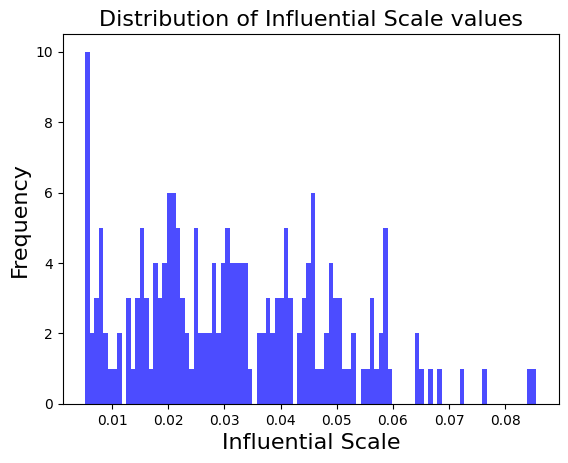

In [46]:
import matplotlib.pyplot as plt

hist_output_path = f'./img/{graph_name}-hist.png'
plt.hist(sir_labels, bins=100, color='blue', alpha=0.7)
plt.xlabel("Influential Scale", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Influential Scale values", fontsize=16)
plt.savefig(hist_output_path, dpi=300, bbox_inches='tight')
plt.show()


This plot shows exactly why sigmoid shouldn't be used

because if most of the values are gathered close to 0 or 1 (in this case 0) then sigmoid wont work very well

this is because of "the vanishing gradients problem: that sigmoid as an activation function brings

## Generating Node Data On-the-Fly
Why??

With this approach, you call adjacency_mat and channel_set for each node during training or evaluation, generating the data just in time.

### Benefits:
* **Memory Efficiency**: You won’t need to store large feature matrices for all nodes, which is helpful if you’re working with a large dataset.
* **Flexibility**: Adjustments to L or feature calculations don’t require re-generating or re-saving all matrices; the latest function logic is always applied.
### Drawbacks:
* **Speed**: Generating matrices on-the-fly can slow down training, especially if creating adjacency_mat and channel_set is computationally expensive.
* **DataLoader Considerations**: You’ll need a custom PyTorch Dataset that generates data for each node when accessed.

In [47]:

def adjancency_mat(G, node, graph_feature_path, L= 9):
    neighbors = list(G.neighbors(node))
    df = pd.read_csv(graph_feature_path)
    # Ensure the DataFrame is indexed by 'Node' to make lookups easier
    df.set_index('Node', inplace=True)
    
    # Sort neighbors by their WiD3 values
    sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, 'WiD3'], reverse=True)
    sorted_neighbors.insert(0, node) #insert node at position zero of the list 

    ad_matrix = np.zeros((L, L))
    # Fill the adjacency matrix based on connections in G
    for i, node_i in enumerate(sorted_neighbors[:L]):
        for j, node_j in enumerate(sorted_neighbors[:L]):
            if G.has_edge(node_i, node_j):  # Check if there's an edge between node_i and node_j
                ad_matrix[i, j] = 1  # Set 1 if there is an edge

    return ad_matrix
#TODO: check whether the neighbors should be sorted with the same WiXt
def channel_set(L, adj_matrix, G, graph_feature_path, WiXt,  node):  #wiDt= 'WiD3'
    df = pd.read_csv(graph_feature_path)
    # Ensure the DataFrame is indexed by 'Node' to make lookups easier
    df.set_index('Node', inplace=True)

    neighbors = list(G.neighbors(node))
    # Sort neighbors by their WiD3 values

    # TODO: see what changes if you sort by different things, just remember the sorting for adjacency matrix and this function should be the same
    # sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, WiXt], reverse=True)
    sorted_neighbors = sorted(neighbors, key=lambda x: df.at[x, 'WiD3'], reverse=True)
    sorted_neighbors.insert(0, node) #insert node at position zero of the list 

    deg_chanl_set = np.zeros((L , L)) 
    for l in range(L): 
        for k in range(L):
            if l == k: 
                deg_chanl_set[l, k] = df.at[node, WiXt]  # WiXt+ alk(which is always 0)
            elif k != 0 and l == 0 and adj_matrix[0, k]: # if adj_matrix[0, k] is 0 then this is a zero-padding and k_node doesnt exist
                k_node = sorted_neighbors[k]
                deg_chanl_set[0, k] = adj_matrix[0, k] * df.at[k_node, WiXt] 
            elif l != 0 and k == 0 and adj_matrix[l, 0]!=0 : 
                l_node = sorted_neighbors[l]
                deg_chanl_set[l, 0] = adj_matrix[l, 0] * df.at[l_node, WiXt] 
            else: 
                deg_chanl_set[l, k] = adj_matrix[l, k] 
    return deg_chanl_set


# L = 4
# node = 5
# ad_mat = adjancency_mat(G, node, csv_filename, L)
# print("-------")
# print(channel_set(L, ad_mat, G, csv_filename, 'WiD3', node))\
# channel_set(L, ad_mat, G, csv_filename, 'WiH3', node)



In [48]:

class NodeDataset(Dataset):
    def __init__(self, G, nodes, graph_feature_path, labels, L):
        self.G = G
        self.nodes = nodes   #TODO: CHECK ITS ALIGNED
        self.graph_feature_path = graph_feature_path
        self.labels = labels  # SIR labels aligned with nodes #TODO: CHECK ITS ALIGNED
        self.L = L

    def __len__(self):
        return len(self.nodes)
    
    def __getitem__(self, idx):
        node = self.nodes[idx]  #TODO: CHECK ITS ALIGNED
        
        # Generate adjacency matrix and channel sets on the fly
        adj_matrix = adjancency_mat(self.G, node, self.graph_feature_path, L=self.L)

        degree_channel = np.zeros((3, self.L, self.L))  # 3 layers for WiD1, WiD2, WiD3
        degree_channel[0] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD1', node)
        degree_channel[1] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD2', node)
        degree_channel[2] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiD3', node)

        # Similarly for H-index channels
        h_index_channel = np.zeros((3, self.L, self.L))  # 3 layers for WiH1, WiH2, WiH3
        h_index_channel[0] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH1', node)
        h_index_channel[1] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH2', node)
        h_index_channel[2] = channel_set(self.L, adj_matrix, self.G, self.graph_feature_path, 'WiH3', node) 
              
        label = self.labels[idx]
        
        # Convert to tensors if using PyTorch
        degree_channel = torch.tensor(degree_channel, dtype=torch.float32) 
        h_index_channel = torch.tensor(h_index_channel, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)    #TODO: MAY NEED TO CHANGE TO FLOAT64
        #  Using float64 can also slow down your model's training time. Most hardware, such as GPUs, is optimized for float32 computations. As a result, using float64 may make operations slower because GPUs are less efficient at handling double-precision computations.
        # wont be using float64(double)

        return degree_channel, h_index_channel, label


Output Size=⌊ (Input Size+2×Padding−Kernel Size)  /  Stride   ⌋+1
MaxPool2d Layer: Halves the spatial size.


1. nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1)

(9+2*1+2/1)+1 = 10
(3, 9, 9) -> (16, 10, 10)

2. nn.MaxPool2d(kernel_size=2, stride=2)

(16, 10, 10) -> (16, 5, 5)

3. nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),

(16, 5, 5) -> (32, 6, 6)

4. nn.MaxPool2d(kernel_size=2, stride=2)

(32, 6, 6) -> (32, 3, 3)

5. Flattening: degree_out.view(degree_out.size(0), -1)
(32, 3, 3) -> (32 * 3 * 3)

(32, 3, 3) -> (288)

The output from each branch will have the shape (batch_size, 32, 3, 3).
When flattened, this becomes (batch_size, 32 * 3 * 3) = (batch_size, 288).
Since I have two branches, the concatenated output will have a shape of (batch_size, 288 * 2) = (batch_size, 576).

In [49]:
class InfluenceCNN(nn.Module):
    def __init__(self, input_size):
        super(InfluenceCNN, self).__init__()
        
        # Degree-based channel set convolutional branch
        self.degree_conv = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1),  # (3, 9, 9) -> (16, 10, 10)
            nn.BatchNorm2d(16),  # Add Batch Normalization
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.01), #TODO
            nn.MaxPool2d(kernel_size=2, stride=2),  # (16, 10, 10) -> (16, 5, 5)
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),  # (16, 5, 5) -> (32, 6, 6)
            nn.BatchNorm2d(32),  # Add Batch Normalization
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.01), #TODO
            nn.MaxPool2d(kernel_size=2, stride=2)  # (32, 6, 6) -> (32, 3, 3)
        )

        # H-index-based channel set convolutional branch
        self.h_index_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(16),  # Add Batch Normalization
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.01), #TODO
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),  # Add Batch Normalization
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.01), #TODO
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling (2,2)
        )

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size of each channel is (1, 1), we have 32 channels: (batch_size, 32, 1, 1)

        # Fully connected layers after concatenation
        self.fc = nn.Sequential(
            nn.Linear(32 * 2, 128),  # Adjusted flattened size: 32 from degree + 32 from H-index
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.01), #TODO
            nn.Linear(128, 1)  # Single output for regression
        )

    def forward(self, degree_input, h_index_input):
        # Pass through each convolutional branch
        degree_out = self.degree_conv(degree_input)

        h_index_out = self.h_index_conv(h_index_input)


        # Apply Global Average Pooling
        degree_out = self.global_avg_pool(degree_out)  # Shape: (batch_size, 32, 1, 1)
        h_index_out = self.global_avg_pool(h_index_out)  # Shape: (batch_size, 32, 1, 1)

        # Flatten and concatenate
        degree_out = degree_out.view(degree_out.size(0), -1)
        h_index_out = h_index_out.view(h_index_out.size(0), -1)

        combined = torch.cat((degree_out, h_index_out), dim=1)

        # Fully connected layers for prediction
        output = self.fc(combined)
        
        # Apply sigmoid activation to constrain output to [0, 1]  #TODO: checck cause this wasnt part of the model
        output = torch.sigmoid(output) # this didnt work, why though? i dont know   
        
        return output



## Batch Size in the Context of Multiple Graphs
When working with multiple graphs, the number of nodes across all graphs combined can vary widely depending on the dataset. For example:

- Graph 1 might have 1,000 nodes.
- Graph 2 might have 5,000 nodes.
- Graph 3 might have 50 nodes.

The total number of nodes across these graphs is 
1,000+5,000+50=6,050.

1. If you set the batch size too high relative to the total number of nodes:

- Memory Constraints: A large batch size might not fit in your GPU or system memory, especially if each node has multiple channels and adjacency matrices.
- Wasted Computation: If the total number of nodes is small, a large batch size might result in under-utilization of your training iterations (e.g., a batch size of 1,024 for 6,050 nodes would only perform 6 iterations per epoch).


2. If the batch size is too small:

- Slower Training: Smaller batches result in more gradient updates per epoch, which might slow down convergence.
- Noisy Gradients: Smaller batches increase the variance of gradient estimates, potentially causing instability in training.

## Choosing an Appropriate Batch Size
To determine the right batch size, consider:

- Memory Usage: The batch size should fit comfortably in your GPU or CPU memory. 
For example:
For dense adjacency matrices (L×L×3) and feature channels, a batch size of 32 or 64 may work on GPUs with 8GB to 12GB of memory.

- Dataset Size: For smaller datasets, ensure the batch size divides evenly into the total number of nodes to avoid excessive padding or incomplete batches. 

For example:
If the total number of nodes is 6,050, a batch size of 50 or 100 would give 121 or 61 batches per epoch, respectively.
Efficiency: Larger batch sizes are more efficient for GPU computation but require more memory. Start with smaller batches (e.g., 16 or 32) and increase if memory allows.

In [50]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Reserved GPU Memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    print(f"Allocated GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Free GPU Memory: {(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")
else:
    print("CUDA is not available.")


GPU: NVIDIA GeForce MX150
Total GPU Memory: 2.15 GB
Reserved GPU Memory: 0.02 GB
Allocated GPU Memory: 0.02 GB
Free GPU Memory: 0.01 GB


In [51]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [52]:
# Assuming you have all the nodes and labels loaded properly
nodes = labels_df['Node'].values
sir_labels = labels_df['SIR'].values

# Split into training and validation sets (80% train, 20% validation)
train_nodes, val_nodes, train_labels, val_labels = train_test_split(nodes, sir_labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = NodeDataset(G, train_nodes, graph_feature_path, train_labels, L=9)
val_dataset = NodeDataset(G, val_nodes, graph_feature_path, val_labels, L=9)


train_nodes[1],train_labels[1]   #just checking that its correctly split and gives the correct node

(6, 0.005308)

In [53]:
# Create DataLoaders:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  #TODO: the paper uses batch_size of 4
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [54]:
# Define the Model, Loss Function, and Optimizer:


# Define the model
model = InfluenceCNN(input_size=9)  # Adjust input_size according to your data

# Apply weight initialization
model.apply(initialize_weights)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # For regression
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs=20


In [56]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
val_losses = []
spearman_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for degree_batch, h_index_batch, label_batch in train_loader:
        degree_batch, h_index_batch, label_batch = degree_batch.to(device), h_index_batch.to(device), label_batch.to(device)
        optimizer.zero_grad()

        output = model(degree_batch, h_index_batch).squeeze()
        loss = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * degree_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients for validation
        for degree_batch, h_index_batch, label_batch in val_loader:
            degree_batch, h_index_batch, label_batch = degree_batch.to(device), h_index_batch.to(device), label_batch.to(device)
            
            # Forward pass
            output = model(degree_batch, h_index_batch).squeeze()

            # Print the output range for debugging
            print(f"Output range: {output.min().item()} - {output.max().item()}")

            # Compute loss
            loss = criterion(output, label_batch)
            val_loss += loss.item() * degree_batch.size(0)

            # Collect predictions and labels
            all_preds.extend(output.cpu().numpy())
            all_labels.extend(label_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Check for constant arrays before computing Spearman correlation
    if np.std(all_preds) > 0 and np.std(all_labels) > 0:
        spearman_corr, _ = spearmanr(all_preds, all_labels)
    else:
        spearman_corr = 0  # Set to 0 if one of the arrays is constant

    spearman_scores.append(spearman_corr)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Spearman Rank Correlation: {spearman_corr:.4f}")


Output range: 0.0071843406185507774 - 0.03185982629656792
Output range: 0.007848833687603474 - 0.03587888181209564
Output range: 0.004331678617745638 - 0.02438984252512455
Output range: 0.008029039017856121 - 0.014304297976195812
Output range: 0.007726638112217188 - 0.034434836357831955
Output range: 0.007401686627417803 - 0.013967999257147312
Output range: 0.005861874669790268 - 0.035689882934093475
Output range: 0.0053640748374164104 - 0.02258947305381298
Output range: 0.005326020065695047 - 0.031370848417282104
Output range: 0.008941169828176498 - 0.014739328995347023
Epoch [1/20], Train Loss: 0.0036, Val Loss: 0.0010, Spearman Rank Correlation: -0.9572
Output range: 0.01706567034125328 - 0.04248872771859169
Output range: 0.022656917572021484 - 0.03683194890618324
Output range: 0.02647404931485653 - 0.04231317713856697
Output range: 0.029963262379169464 - 0.03950512036681175
Output range: 0.02283410355448723 - 0.04028891399502754
Output range: 0.026821861043572426 - 0.04256874322891

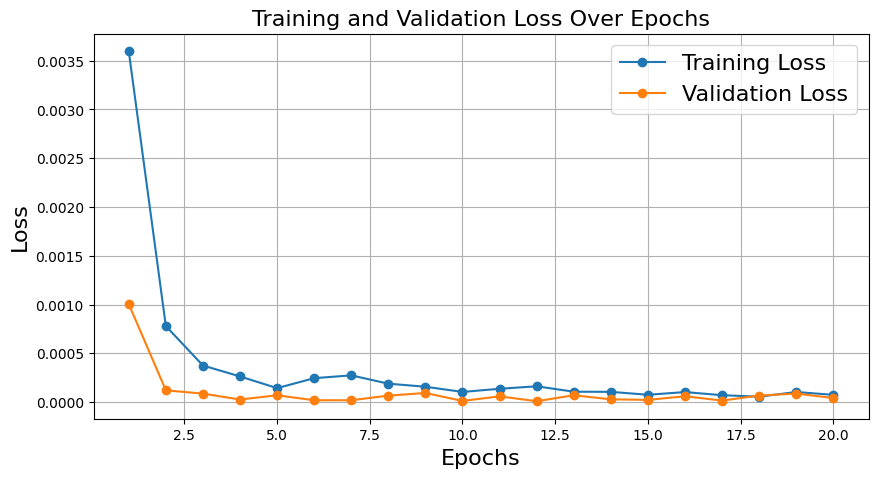

<Figure size 640x480 with 0 Axes>

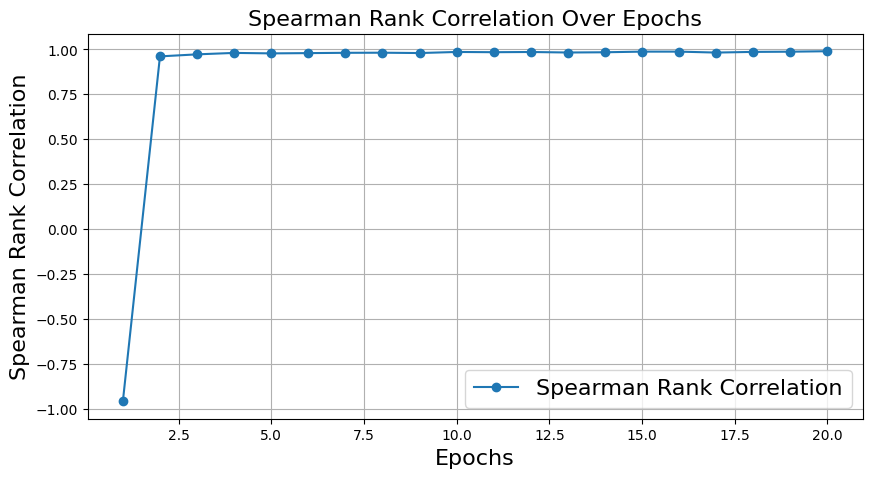

<Figure size 640x480 with 0 Axes>

In [57]:

# Plotting Training and Validation Loss
loss_output_path = f'./img/{graph_name}-loss.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
plt.savefig(loss_output_path, dpi=300, bbox_inches='tight')

# Plotting Spearman Rank Correlation
spearman_rank_output_path = f'./img/{graph_name}-spearman_rank.png'

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), spearman_scores, label="Spearman Rank Correlation", marker='o')
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Spearman Rank Correlation", fontsize=16)
plt.title("Spearman Rank Correlation Over Epochs", fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
plt.savefig(spearman_rank_output_path, dpi=300, bbox_inches='tight')



In [58]:
# 6. Validation Loop:

model.eval()  # Set model to evaluation mode

# Tracking validation loss
val_loss = 0.0

with torch.no_grad():  # No gradient calculation during validation
    for degree_input, h_index_input, label in val_loader:
        degree_input, h_index_input, label = degree_input.to(device), h_index_input.to(device), label.to(device)

        # Forward pass
        output = model(degree_input, h_index_input)

        # Calculate loss
        loss = criterion(output.squeeze(), label)  # squeeze to match dimensions
        val_loss += loss.item()

print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


Validation Loss: 0.0000


In [59]:
#  Save the Model (optional):
torch.save(model.state_dict(), 'influence_cnn_model.pth')


In [60]:
# To load the model later
model = InfluenceCNN(input_size=9)
model.load_state_dict(torch.load('influence_cnn_model.pth', weights_only=True))
model.eval()


InfluenceCNN(
  (degree_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (h_index_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), pa